# Data Preprocessing
First import the data.

In [1]:
import numpy as np
X_test = np.load("project/X_test.npy")
y_test = np.load("project/y_test.npy")
person_train_valid = np.load("project/person_train_valid.npy")
X_train_valid = np.load("project/X_train_valid.npy")
y_train_valid = np.load("project/y_train_valid.npy")
person_test = np.load("project/person_test.npy")

In [2]:
# Ignore EOG data from last 3 of 25 electrodes
# Transpose data so that the second dimension is timesteps
X_test = X_test[:, :-3, :]
X_test = X_test.transpose([0, 2, 1])
X_train_valid = X_train_valid[:, :-3, :]
X_train_valid = X_train_valid.transpose([0, 2, 1])

In [3]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 1000, 22)
Test data shape: (443, 1000, 22)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [4]:
from sklearn import preprocessing

In [5]:
np.random.seed(0)

In [6]:
num_trials = X_train_valid.shape[0]
num_timesteps = X_train_valid.shape[1]
num_features = X_train_valid.shape[2]

In [7]:
# Turn labels into categories, i.e. y values of 0-3
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train_valid)
y_train_valid_classes = le.transform(y_train_valid)

In [26]:
rand_idx = np.random.permutation(num_trials)
rand_idx 

array([1593,  463,  901, ..., 1091,  880, 1750])

In [9]:
# Create randomized train and validation dataset split
split = int(num_trials * 0.80)
X_train = X_train_valid[rand_idx][:split]
y_train = y_train_valid_classes[rand_idx][:split]
person_train = person_train_valid[rand_idx][:split]

X_valid = X_train_valid[rand_idx][split:]
y_valid = y_train_valid_classes[rand_idx][split:]
person_valid = person_train_valid[rand_idx][split:]

In [33]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras import optimizers
from keras.layers.normalization import BatchNormalization

In [45]:
checkpoint_path = 'checkpoints/EEG_prediction.ckpt'
import keras.callbacks

# Create checkpoint callback
cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True, 
                                                 monitor='val_loss',
                                                 save_best_only=True, 
                                                 mode='auto',
                                                 verbose=1)

In [46]:
# Build model architecture
model = Sequential()

model.add(GRU(40, dropout=0.2, input_shape=(num_timesteps, num_features), return_sequences=True))
model.add(BatchNormalization())

model.add(GRU(20, dropout=0.1))
model.add(BatchNormalization())

model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(4, activation='softmax'))
#model.load_weights(checkpoint_path)

In [47]:
# Fit model on training set, validate with validation data
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=200, batch_size=64, verbose=1, callbacks = [cp_callback])

Train on 1692 samples, validate on 423 samples
Epoch 1/200
1692/1692 [==============================] - 62s 37ms/step - loss: 1.8440 - acc: 0.2630 - val_loss: 1.6986 - val_acc: 0.2388

Epoch 00001: val_loss improved from inf to 1.69855, saving model to checkpoints/EEG_prediction.ckpt
Epoch 2/200
1692/1692 [==============================] - 54s 32ms/step - loss: 1.7224 - acc: 0.2541 - val_loss: 1.6458 - val_acc: 0.2411

Epoch 00002: val_loss improved from 1.69855 to 1.64580, saving model to checkpoints/EEG_prediction.ckpt
Epoch 3/200
1692/1692 [==============================] - 54s 32ms/step - loss: 1.6031 - acc: 0.2595 - val_loss: 1.5699 - val_acc: 0.2553

Epoch 00003: val_loss improved from 1.64580 to 1.56987, saving model to checkpoints/EEG_prediction.ckpt
Epoch 4/200
1692/1692 [==============================] - 55s 32ms/step - loss: 1.5852 - acc: 0.2577 - val_loss: 1.5339 - val_acc: 0.2435

Epoch 00004: val_loss improved from 1.56987 to 1.53394, saving model to checkpoints/EEG_predi

1692/1692 [==============================] - 54s 32ms/step - loss: 1.3773 - acc: 0.3014 - val_loss: 1.4071 - val_acc: 0.2340

Epoch 00037: val_loss did not improve from 1.40588
Epoch 38/200
1692/1692 [==============================] - 54s 32ms/step - loss: 1.3715 - acc: 0.3245 - val_loss: 1.4077 - val_acc: 0.2459

Epoch 00038: val_loss did not improve from 1.40588
Epoch 39/200
1692/1692 [==============================] - 54s 32ms/step - loss: 1.3827 - acc: 0.2902 - val_loss: 1.4082 - val_acc: 0.2482

Epoch 00039: val_loss did not improve from 1.40588
Epoch 40/200
1692/1692 [==============================] - 54s 32ms/step - loss: 1.3663 - acc: 0.3091 - val_loss: 1.4073 - val_acc: 0.2553

Epoch 00040: val_loss did not improve from 1.40588
Epoch 41/200
1692/1692 [==============================] - 54s 32ms/step - loss: 1.3673 - acc: 0.3085 - val_loss: 1.4071 - val_acc: 0.2459

Epoch 00041: val_loss did not improve from 1.40588
Epoch 42/200
1692/1692 [==============================] - 54s 3

1692/1692 [==============================] - 54s 32ms/step - loss: 1.3144 - acc: 0.3924 - val_loss: 1.4604 - val_acc: 0.2388

Epoch 00080: val_loss did not improve from 1.40588
Epoch 81/200
1692/1692 [==============================] - 53s 32ms/step - loss: 1.3033 - acc: 0.3765 - val_loss: 1.4643 - val_acc: 0.2246

Epoch 00081: val_loss did not improve from 1.40588
Epoch 82/200
1692/1692 [==============================] - 54s 32ms/step - loss: 1.3218 - acc: 0.3741 - val_loss: 1.4632 - val_acc: 0.2246

Epoch 00082: val_loss did not improve from 1.40588
Epoch 83/200
1692/1692 [==============================] - 54s 32ms/step - loss: 1.3073 - acc: 0.3859 - val_loss: 1.4541 - val_acc: 0.2340

Epoch 00083: val_loss did not improve from 1.40588
Epoch 84/200
1692/1692 [==============================] - 54s 32ms/step - loss: 1.3025 - acc: 0.3830 - val_loss: 1.4547 - val_acc: 0.2364

Epoch 00084: val_loss did not improve from 1.40588
Epoch 85/200
1692/1692 [==============================] - 54s 3

1692/1692 [==============================] - 54s 32ms/step - loss: 1.1811 - acc: 0.4693 - val_loss: 1.6016 - val_acc: 0.2222

Epoch 00123: val_loss did not improve from 1.40588
Epoch 124/200
1692/1692 [==============================] - 54s 32ms/step - loss: 1.1839 - acc: 0.4693 - val_loss: 1.5896 - val_acc: 0.2151

Epoch 00124: val_loss did not improve from 1.40588
Epoch 125/200
1692/1692 [==============================] - 54s 32ms/step - loss: 1.1722 - acc: 0.4770 - val_loss: 1.6002 - val_acc: 0.2293

Epoch 00125: val_loss did not improve from 1.40588
Epoch 126/200
1692/1692 [==============================] - 54s 32ms/step - loss: 1.1832 - acc: 0.4663 - val_loss: 1.6085 - val_acc: 0.2411

Epoch 00126: val_loss did not improve from 1.40588
Epoch 127/200
1692/1692 [==============================] - 54s 32ms/step - loss: 1.1616 - acc: 0.4657 - val_loss: 1.6120 - val_acc: 0.2104

Epoch 00127: val_loss did not improve from 1.40588
Epoch 128/200
1692/1692 [==============================] - 

1692/1692 [==============================] - 54s 32ms/step - loss: 1.0482 - acc: 0.5437 - val_loss: 1.7299 - val_acc: 0.2317

Epoch 00166: val_loss did not improve from 1.40588
Epoch 167/200
1692/1692 [==============================] - 54s 32ms/step - loss: 1.0534 - acc: 0.5550 - val_loss: 1.7255 - val_acc: 0.2293

Epoch 00167: val_loss did not improve from 1.40588
Epoch 168/200
1692/1692 [==============================] - 54s 32ms/step - loss: 1.0570 - acc: 0.5437 - val_loss: 1.7563 - val_acc: 0.2364

Epoch 00168: val_loss did not improve from 1.40588
Epoch 169/200
1692/1692 [==============================] - 54s 32ms/step - loss: 1.0524 - acc: 0.5455 - val_loss: 1.7769 - val_acc: 0.2246

Epoch 00169: val_loss did not improve from 1.40588
Epoch 170/200
1692/1692 [==============================] - 53s 32ms/step - loss: 1.0369 - acc: 0.5585 - val_loss: 1.7631 - val_acc: 0.2388

Epoch 00170: val_loss did not improve from 1.40588
Epoch 171/200
1692/1692 [==============================] - 

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

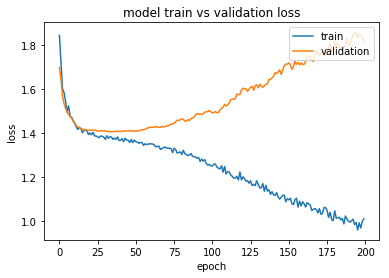

In [48]:
# plot train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()